In [15]:
from __future__ import division, print_function
from keras import backend as K
from keras.applications import vgg16
from keras.layers import Input, merge
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten, Lambda
from keras.models import Sequential, Model
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from random import shuffle
from scipy.misc import imresize
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [16]:
DATA_DIR = "../data"
IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos")

File naming conventions are as follows:

* first 4 numbers of filename prefix refer to the group
* next 2 numbers refer to the image in the group.

For example: 100000.jpg and 100002.jpg are "similar", but 123700.jpg is "different".

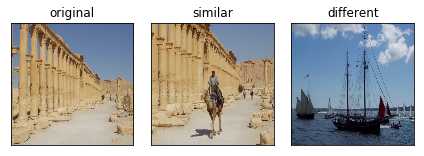

In [17]:
def show_img(sid, img_file, img_title):
    plt.subplot(sid)
    plt.title(img_title)
    plt.xticks([])
    plt.yticks([])
    img = imresize(plt.imread(img_file), (512, 512))
    plt.imshow(img)
    
show_img(131, os.path.join(IMAGE_DIR, "115200.jpg"), "original")
show_img(132, os.path.join(IMAGE_DIR, "115201.jpg"), "similar")
show_img(133, os.path.join(IMAGE_DIR, "123700.jpg"), "different")
plt.tight_layout()
plt.show()

In [18]:
def get_random_image(img_groups, group_names, gid):
    gname = group_names[gid]
    photos = img_groups[gname]
    pid = np.random.choice(np.arange(len(photos)), size=1)[0]
    pname = photos[pid]
    return gname + pname + ".jpg"
    
def create_triples(image_dir):
    img_groups = {}
    for img_file in os.listdir(image_dir):
        prefix, suffix = img_file.split(".")
        gid, pid = prefix[0:4], prefix[4:]
        if img_groups.has_key(gid):
            img_groups[gid].append(pid)
        else:
            img_groups[gid] = [pid]
    pos_triples, neg_triples = [], []
    # positive pairs are any combination of images in same group
    for key in img_groups.keys():
        triples = [(key + x[0] + ".jpg", key + x[1] + ".jpg", 1) 
                 for x in itertools.combinations(img_groups[key], 2)]
        pos_triples.extend(triples)
    # need equal number of negative examples
    group_names = list(img_groups.keys())
    for i in range(len(pos_triples)):
        g1, g2 = np.random.choice(np.arange(len(group_names)), size=2, replace=False)
        left = get_random_image(img_groups, group_names, g1)
        right = get_random_image(img_groups, group_names, g2)
        neg_triples.append((left, right, 0))
    pos_triples.extend(neg_triples)
    shuffle(pos_triples)
    return pos_triples

triples_data = create_triples(IMAGE_DIR)

print("# image triples:", len(triples_data))
[x for x in triples_data[0:5]]

# image triples: 4144


[('126002.jpg', '123300.jpg', 0),
 ('108900.jpg', '114700.jpg', 0),
 ('136704.jpg', '136703.jpg', 1),
 ('139002.jpg', '139005.jpg', 1),
 ('129202.jpg', '129200.jpg', 1)]

In [19]:
def load_image(image_name):
    if not image_cache.has_key(image_name):
        image = plt.imread(os.path.join(IMAGE_DIR, image_name)).astype(np.float32)
        image = imresize(image, (224, 224))
        image = np.divide(image, 256)
        image_cache[image_name] = image
    return image_cache[image_name]
    
def generate_image_triples_batch(image_triples, batch_size, shuffle=False):
    while True:
        # loop once per epoch
        if shuffle:
            indices = np.random.permutation(np.arange(len(image_triples)))
        else:
            indices = np.arange(len(image_triples))
        shuffled_triples = [image_triples[ix] for ix in indices]
        num_batches = len(shuffled_triples) // batch_size
        for bid in range(num_batches):
            # loop once per batch
            images_left, images_right, labels = [], [], []
            batch = shuffled_triples[bid * batch_size : (bid + 1) * batch_size]
            for i in range(batch_size):
                lhs, rhs, label = batch[i]
                images_left.append(load_image(lhs))
                images_right.append(load_image(rhs))              
                labels.append(label)
            Xlhs = np.array(images_left)
            Xrhs = np.array(images_right)
            Y = np_utils.to_categorical(np.array(labels), num_classes=2)
            yield ([Xlhs, Xrhs], Y)

            
BATCH_SIZE = 64

split_point = int(len(triples_data) * 0.7)
triples_train, triples_test = triples_data[0:split_point], triples_data[split_point:]

In [20]:
def create_base_network(input_shape):
    seq = Sequential()
    # CONV => RELU => POOL
    seq.add(Conv2D(20, kernel_size=5, padding="same", input_shape=input_shape))
    seq.add(Activation("relu"))
    seq.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # CONV => RELU => POOL
    seq.add(Conv2D(50, kernel_size=5, padding="same"))
    seq.add(Activation("relu"))
    seq.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # Flatten => RELU
    seq.add(Flatten())
    seq.add(Dense(500))
    
    return seq

def cosine_distance(vecs, normalize=False):
    x, y = vecs
    if normalize:
        x = K.l2_normalize(x, axis=0)
        y = K.l2_normalize(x, axis=0)
    return K.prod(K.stack([x, y], axis=1), axis=1)

def cosine_distance_output_shape(shapes):
    return shapes[0]

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * 
                  K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(preds, labels):
    return labels[preds.ravel() < 0.5].mean()

In [21]:
input_shape = (224, 224, 3)
base_network = create_base_network(input_shape)

image_left = Input(shape=input_shape)
image_right = Input(shape=input_shape)

vector_left = base_network(image_left)
vector_right = base_network(image_right)

distance = Lambda(cosine_distance, 
                  output_shape=cosine_distance_output_shape)([vector_left, vector_right])

# fc1 = Dense(512, kernel_initializer="glorot_uniform")(distance)
# fc1 = Dropout(0.2)(fc1)
# fc1 = Activation("relu")(fc1)

fc1 = Dense(128, kernel_initializer="glorot_uniform")(distance)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc1)
pred = Activation("softmax")(pred)

model = Model(inputs=[image_left, image_right], outputs=pred)
# model.summary()

In [24]:
# model.compile(loss=contrastive_loss, optimizer="rmsprop")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
NUM_EPOCHS = 10

image_cache = {}
train_gen = generate_image_triples_batch(triples_train, BATCH_SIZE, shuffle=True)
val_gen = generate_image_triples_batch(triples_test, BATCH_SIZE, shuffle=False)

num_train_steps = len(triples_train) // BATCH_SIZE
num_val_steps = len(triples_test) // BATCH_SIZE

history = model.fit_generator(train_gen,
                              steps_per_epoch=num_train_steps,
                              epochs=NUM_EPOCHS,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/10
45/45 [==============================] - 412s - loss: 0.6932 - acc: 0.5049 - val_loss: 0.6933 - val_acc: 0.4918

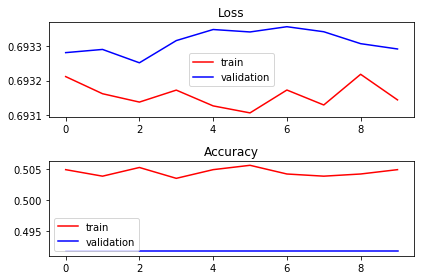

In [26]:
plt.subplot(211)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()